In [65]:
#Start here once codon stats has been run on the cluster 
#script to process all genes into a single dataframe, run from /Users/aliciadarnell 
#This needs to be run to generate "data" dictionary before I use the following code to analyze results.
import cPickle as pickle
import re
import pandas
import sys
import numpy
from IPython.core.display import clear_output

processedFiles = !ls ../rp_pickled_files/20140829_293T_q99ltorin/geneStats293*.pickled

df = list()

for File in processedFiles:
    #print File
    temp = pandas.DataFrame.from_dict(  pickle.load( open( File, 'rb' ) ), orient='index' )                            
    sample = re.search( 'geneStats293(.*)\.pickled', File ).groups( 1 )[0]                
    print sample
    
    if len( df ) > 0:
        df.append( temp[['totalCountsCds','readDensityPerNt']].rename( columns = {'totalCountsCds': 'counts' + sample, 'readDensityPerNt':'rpnt' + sample} ) )
    else:
        df.append( temp.drop( ['seq','totalCountsTranscript'], axis = 1).rename( columns = {'totalCountsCds': 'counts' + sample, 'readDensityPerNt':'rpnt' + sample} ) )
        
    print File
    sys.stdout.flush()
    
annotations = pandas.load( '../rp_pickled_files/refseq_annotations.pickled' )
df.append( annotations )
        
data = pandas.concat( df, join='inner', axis=1 )

for key in data.keys():
    if key.startswith( 'counts' ):
        data[ key ] = data[ key ].apply( lambda x: numpy.round( x, 0) )                
    if key.startswith( 'rpnt' ):
        data[ key ] = data[ key ].apply( lambda x: numpy.round( x, 2) )                

data['description'] = map( lambda x: x.replace( 'Homo sapiens ', '' ), data['description'] )
    
clear_output()
data['gene'] = map( lambda x: re.search( '\(([\w\-]+)\),', x ).groups()[0], data['description'] )
data = data.reset_index().rename( columns = {'index':'refseqid'} ).set_index( 'gene' )

In [66]:
len(data)

11038

In [122]:
#I modifed this piece of code from my hela submit 1 analysis to calcuate subset (logical).


from IPython.core.display import HTML

for key in ['counts_gfp_rich','counts_gfp_leu','counts_gfp_arg','counts_gfp_torin_rich','counts_gfp_torin_leu','counts_gfp_torin_arg','counts_wtrag_rich','counts_wtrag_leu','counts_wtrag_arg','counts_q99lrag_rich','counts_q99lrag_leu','counts_q99lrag_arg','counts_monosomes_rich293','counts_monosomes_leu293','counts_monosomes_arg293']:
    subset_key = key.replace( 'counts', 'subset_counts' )
    data[ subset_key ] = data[ key ] > 100 
    
#HTML(data.sort(columns=['refseqid'],ascending=True)[data[subset_key]].to_html())


In [69]:
print data.keys()

Index([refseqid, rpnt_A_mono, end, start, length, counts_A_mono, counts_gfp_arg, rpnt_gfp_arg, counts_gfp_leu, rpnt_gfp_leu, counts_gfp_rich, rpnt_gfp_rich, counts_gfp_torin_arg, rpnt_gfp_torin_arg, counts_gfp_torin_leu, rpnt_gfp_torin_leu, counts_gfp_torin_rich, rpnt_gfp_torin_rich, counts_monosomes_arg293, rpnt_monosomes_arg293, counts_monosomes_leu293, rpnt_monosomes_leu293, counts_monosomes_rich293, rpnt_monosomes_rich293, counts_q99lrag_arg, rpnt_q99lrag_arg, counts_q99lrag_leu, rpnt_q99lrag_leu, counts_q99lrag_rich, rpnt_q99lrag_rich, counts_wtrag_arg, rpnt_wtrag_arg, counts_wtrag_leu, rpnt_wtrag_leu, counts_wtrag_rich, rpnt_wtrag_rich, description, fc_gfprich_over_Amono], dtype=object)


8.66355700748


In [68]:
from IPython.core.display import HTML
import numpy
for key in ['counts_gfp_rich']:
    fc_key = key.replace( 'counts', 'fc' ).replace( 'gfp_rich', 'gfprich_over_Amono' )  #names the new fold change key
    data[ fc_key ] = (numpy.log2( data[ key ] ) - numpy.median(numpy.log2(data[key]))) - (numpy.log2( data[ key.replace( 'gfp_rich', 'A_mono' ) ] ) - numpy.median(numpy.log2(data[ key.replace( 'gfp_rich', 'A_mono' ) ]))) #calculates the new fold change key: log2 counts in rasi mono 293t rich - log2 counts in my gfp rich, so rasi/mine, so x greater than 0 is 2^x more translated in rasi's cells and vice versa for less than 0.


#HTML(data.drop(['end','start','length','counts_gfp_leu','counts_gfp_arg','counts_gfp_torin_rich','counts_gfp_torin_leu','counts_gfp_torin_arg','counts_wtrag_rich','counts_wtrag_leu','counts_wtrag_arg','counts_q99lrag_rich','counts_q99lrag_leu','counts_q99lrag_arg','counts_monosomes_leu293','counts_monosomes_arg293','rpnt_gfp_leu','rpnt_gfp_arg','rpnt_gfp_torin_rich','rpnt_gfp_torin_leu','rpnt_gfp_torin_arg','rpnt_wtrag_rich','rpnt_wtrag_leu','rpnt_wtrag_arg','rpnt_q99lrag_rich','rpnt_q99lrag_leu','rpnt_q99lrag_arg','rpnt_monosomes_leu293','rpnt_monosomes_arg293'],axis=1).sort(columns=['fc_monosomesrich293_over_gfprich'],ascending=True).to_html())

In [74]:
HTML( data[ numpy.logical_and( data['fc_gfprich_over_Amono'] < -2, data['counts_gfp_rich'] > 50, data['counts_A_mono'] > 50)].sort(columns=['fc_gfprich_over_Amono'],ascending=True).to_html() )

,refseqid,rpnt_A_mono,end,start,length,counts_A_mono,counts_gfp_arg,rpnt_gfp_arg,counts_gfp_leu,rpnt_gfp_leu,counts_gfp_rich,rpnt_gfp_rich,counts_gfp_torin_arg,rpnt_gfp_torin_arg,counts_gfp_torin_leu,rpnt_gfp_torin_leu,counts_gfp_torin_rich,rpnt_gfp_torin_rich,counts_monosomes_arg293,rpnt_monosomes_arg293,counts_monosomes_leu293,rpnt_monosomes_leu293,counts_monosomes_rich293,rpnt_monosomes_rich293,counts_q99lrag_arg,rpnt_q99lrag_arg,counts_q99lrag_leu,rpnt_q99lrag_leu,counts_q99lrag_rich,rpnt_q99lrag_rich,counts_wtrag_arg,rpnt_wtrag_arg,counts_wtrag_leu,rpnt_wtrag_leu,counts_wtrag_rich,rpnt_wtrag_rich,description,fc_gfprich_over_Amono
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MTRNR2L2,NM_001190470.1,28.24,1036,949,87,2457,1702,19.56,1183,13.60,953,10.95,1015,11.67,789,9.07,870,10.00,42,0.48,17,0.20,10,0.11,2147,24.68,882,10.14,1000,11.49,2316,26.62,730,8.39,738,8.48,"MT-RNR2-like 2 (MTRNR2L2), mRNA.",-3.506831
NPIPB3,NM_130464.2,0.07,3478,76,3402,228,166,0.05,131,0.04,95,0.03,145,0.04,77,0.02,83,0.02,3,0.00,1,0.00,3,0.00,216,0.06,105,0.03,111,0.03,263,0.08,70,0.02,63,0.02,nuclear pore complex interacting protein famil...,-3.403515
SLC35A4,NM_080670.2,0.20,1703,728,975,194,159,0.16,139,0.14,95,0.10,149,0.15,99,0.10,98,0.10,9,0.01,8,0.01,5,0.01,152,0.16,137,0.14,94,0.10,189,0.19,74,0.08,55,0.06,"solute carrier family 35, member A4 (SLC35A4),...",-3.170538
NPIPB5,NM_001135865.1,0.06,3681,279,3402,205,169,0.05,135,0.04,103,0.03,126,0.04,79,0.02,96,0.03,4,0.00,3,0.00,5,0.00,179,0.05,122,0.04,111,0.03,254,0.07,71,0.02,64,0.02,nuclear pore complex interacting protein famil...,-3.133460
NDST2,NM_003635.3,0.05,3456,804,2652,123,78,0.03,125,0.05,81,0.03,53,0.02,31,0.01,40,0.02,12,0.00,11,0.00,14,0.01,48,0.02,63,0.02,52,0.02,73,0.03,55,0.02,43,0.02,N-deacetylase/N-sulfotransferase (heparan gluc...,-2.743145
KIAA2018,NM_001009899.2,0.03,7149,411,6738,176,63,0.01,117,0.02,120,0.02,89,0.01,82,0.01,90,0.01,8,0.00,5,0.00,7,0.00,60,0.01,98,0.01,79,0.01,65,0.01,88,0.01,70,0.01,"KIAA2018 (KIAA2018), mRNA.",-2.693022
NPIPA1,NM_006985.2,0.09,1053,0,1053,99,122,0.12,74,0.07,68,0.06,74,0.07,36,0.03,64,0.06,4,0.00,6,0.01,6,0.01,126,0.12,56,0.05,90,0.09,151,0.14,38,0.04,30,0.03,nuclear pore complex interacting protein famil...,-2.682375
IDS,NM_000202.5,0.10,1870,217,1653,163,128,0.08,134,0.08,112,0.07,100,0.06,64,0.04,79,0.05,8,0.00,1,0.00,5,0.00,131,0.08,70,0.04,78,0.05,147,0.09,84,0.05,61,0.04,"iduronate 2-sulfatase (IDS), transcript varian...",-2.681854
LRRC37A,NM_014834.4,0.01,5106,3,5103,73,33,0.01,58,0.01,54,0.01,23,0.00,17,0.00,17,0.00,7,0.00,2,0.00,3,0.00,46,0.01,51,0.01,41,0.01,62,0.01,44,0.01,39,0.01,"leucine rich repeat containing 37A (LRRC37A), ...",-2.575418


In [8]:
from IPython.core.display import HTML
import numpy
for key in [:
    te_key = key.replace( 'counts293', 'te' )
    subset_key = key.replace( 'counts293', 'subset_te' )
    data[ te_key ] = numpy.log2( data[ key ] ) - numpy.log2( data[ key.replace( '_mono', '_mrna' ) ] )  #log2 of the value in monosome counts - log2 of the value in mrna counts (replace only monosomes with mrna in that key still leaves the identifier.)
    data[ subset_key ] = numpy.logical_and( data[ key ] > 100, data[ key.replace( '_mono', '_mrna' ) ] > 100 )  #data in monosome counts > 100 and data in the same set of mrna counts > 100
    data[ te_key ] = numpy.round( data[ te_key ] - numpy.median( data[ te_key ][data[ subset_key ]] ), 2 ).apply( lambda x: numpy.round( x, 2) )

#HTML(data.sort(columns=['refseqid'],ascending=True)[data[subset_key]].to_html())

In [53]:
print data.keys()

Index([refseqid, rpnt_A_mono, end, start, length, counts_A_mono, counts_gfp_arg, rpnt_gfp_arg, counts_gfp_leu, rpnt_gfp_leu, counts_gfp_rich, rpnt_gfp_rich, counts_gfp_torin_arg, rpnt_gfp_torin_arg, counts_gfp_torin_leu, rpnt_gfp_torin_leu, counts_gfp_torin_rich, rpnt_gfp_torin_rich, counts_monosomes_arg293, rpnt_monosomes_arg293, counts_monosomes_leu293, rpnt_monosomes_leu293, counts_monosomes_rich293, rpnt_monosomes_rich293, counts_q99lrag_arg, rpnt_q99lrag_arg, counts_q99lrag_leu, rpnt_q99lrag_leu, counts_q99lrag_rich, rpnt_q99lrag_rich, counts_wtrag_arg, rpnt_wtrag_arg, counts_wtrag_leu, rpnt_wtrag_leu, counts_wtrag_rich, rpnt_wtrag_rich, description, fc_gfprich_over_amono], dtype=object)


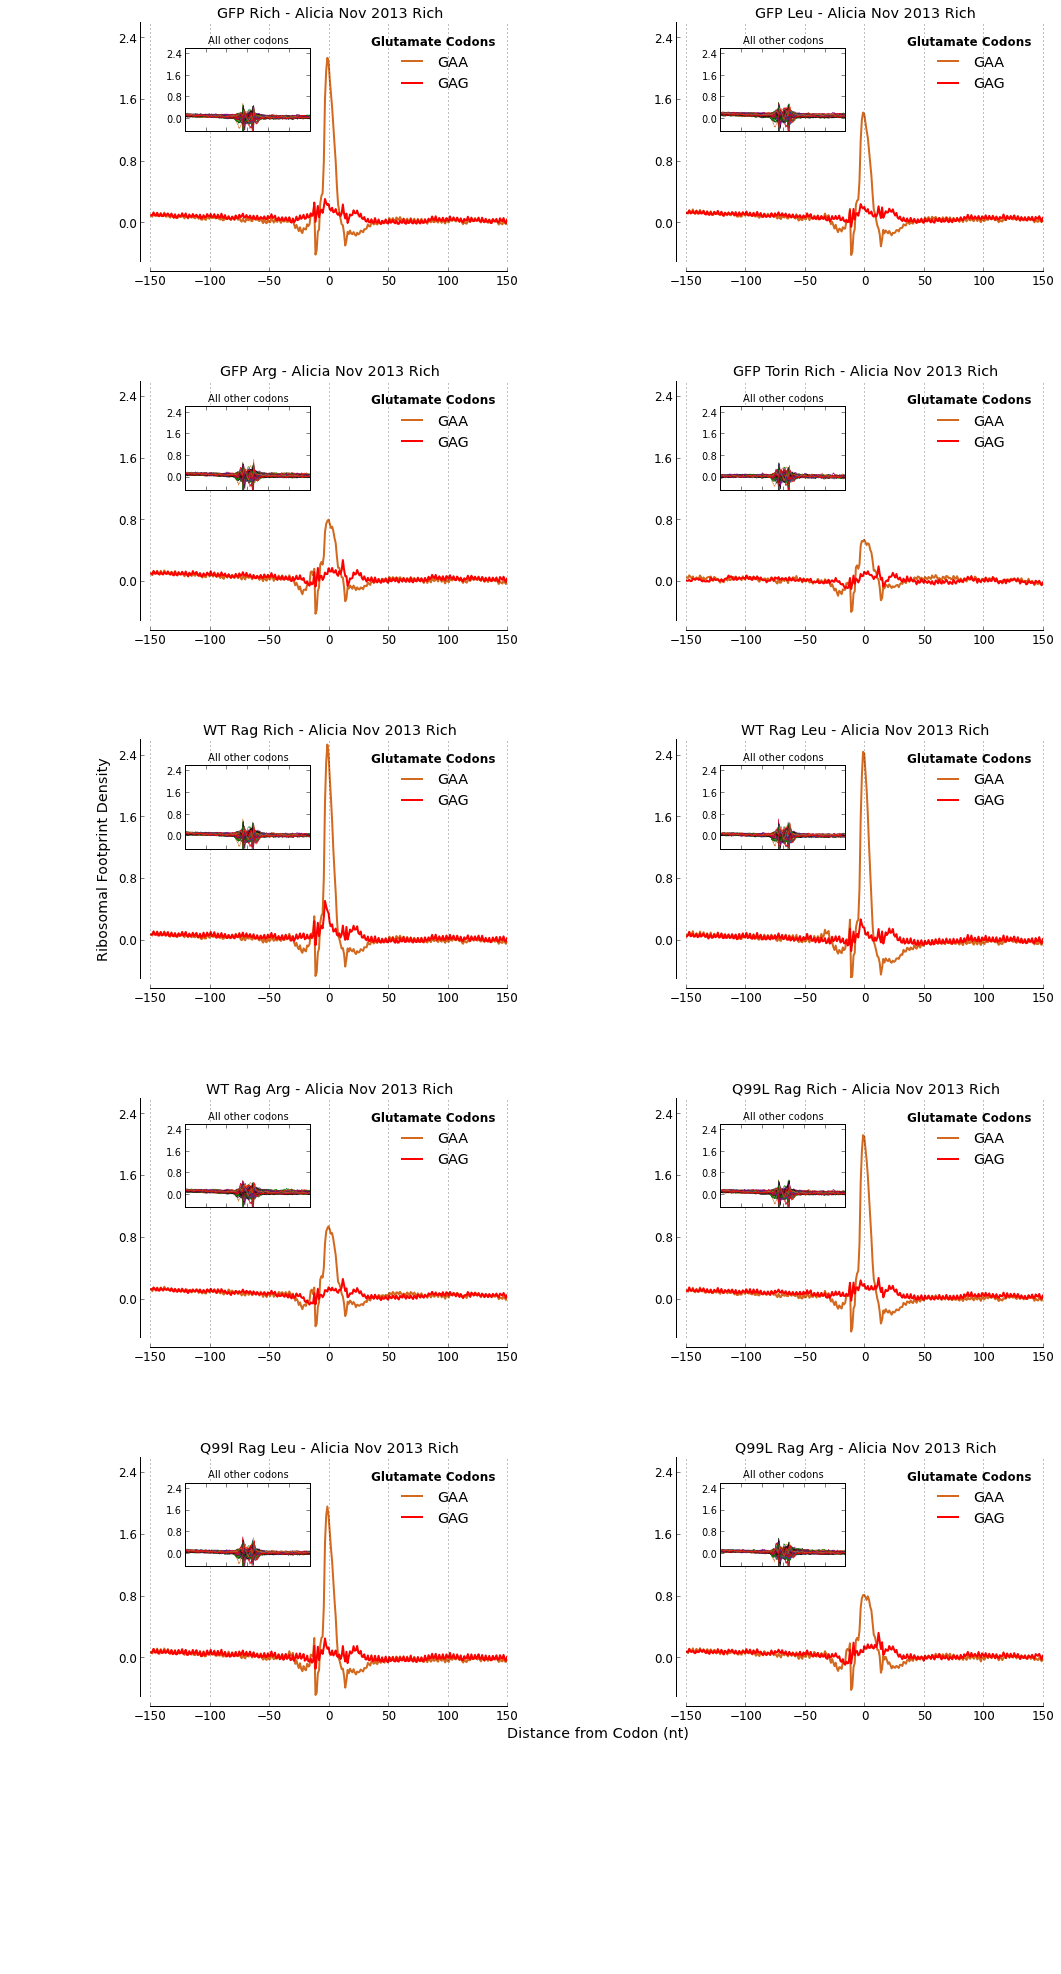

In [83]:
#plot starved-rich ribosome occupancy changes at any codon family

import cPickle as pickle

top_samples = ['gfp_rich','gfp_leu','gfp_arg','gfp_torin_rich','wtrag_rich','wtrag_leu','wtrag_arg','q99lrag_rich','q99lrag_leu','q99lrag_arg']
bottom_samples = ['A_mono','A_mono','A_mono','A_mono','A_mono','A_mono','A_mono','A_mono','A_mono','A_mono']

offset = 150

import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator, NullLocator, MaxNLocator
from Bio.SeqUtils import CodonUsage
from matplotlib.transforms import Bbox


codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
    codon_number_dict[codon] = codon_number
codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Liberation Sans'
plt.rcParams['font.size'] = 12

fig = plt.figure()
common_ax = plt.axes(frameon=False)
common_ax.set_xlabel('Distance from Codon (nt)', fontsize = "larger")
common_ax.set_ylabel(r'Ribosomal Footprint Density', fontsize = "larger")
common_ax.set_xticks([])
common_ax.set_yticks([])
common_ax.yaxis.labelpad = 40
common_ax.xaxis.labelpad = 30

fig.subplots_adjust( wspace=0.5, hspace=0.5 )

edge_colors = ["chocolate", "red", "black", "green", "purple", "darkslateblue"]
summedDensity = dict()
stallingIndex = dict()
for sampleIndex, sample in enumerate( top_samples ):
    sampleStats_top = pickle.load( open( 'processedDataFiles/20140829_293T_q99ltorin/sampleStats293_' + top_samples[sampleIndex] + '.pickled', 'rb' ) )
    sampleStats_bottom = pickle.load( open( 'processedDataFiles/20140829_293T_q99ltorin/sampleStats293_' + bottom_samples[sampleIndex] + '.pickled', 'rb' ) )
    
    summedDensity[top_samples[sampleIndex]] = dict()    
    if re.search( 'gfp_leu', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'GFP Leu - Alicia Nov 2013 Rich'
    elif re.search( 'wtrag_leu', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'WT Rag Leu - Alicia Nov 2013 Rich'
    elif re.search( 'q99lrag_leu', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'Q99l Rag Leu - Alicia Nov 2013 Rich'
    elif re.search( 'gfp_rich', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'GFP Rich - Alicia Nov 2013 Rich'   
    elif re.search( 'q99lrag_rich', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'Q99L Rag Rich - Alicia Nov 2013 Rich' 
    elif re.search( 'gfp_arg', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'GFP Arg - Alicia Nov 2013 Rich'     
    elif re.search( 'wtrag_rich', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'WT Rag Rich - Alicia Nov 2013 Rich'     
    elif re.search( 'wtrag_arg', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'WT Rag Arg - Alicia Nov 2013 Rich'     
    elif re.search( 'q99lrag_arg', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'Q99L Rag Arg - Alicia Nov 2013 Rich'
    elif re.search( 'gfp_torin_rich', top_samples[sampleIndex] ):
        subsetCodons = ['GAG','GAA']
        legendTitle = 'Glutamate Codons'
        axTitle = 'GFP Torin Rich - Alicia Nov 2013 Rich'     
        
    ax = fig.add_subplot( int(numpy.ceil(len(top_samples)/2.0)),2,sampleIndex+1)     
    temp = list()
    
    for codonIndex, codon in enumerate( sorted( filter( lambda codon: codon in subsetCodons, codon_number_dict ) ) ):
        x_vector = numpy.arange(-offset,+offset+1)
        y_vector = sampleStats_top['codonRibosomeOccupancyMedian'][codon] - sampleStats_bottom['codonRibosomeOccupancyMedian'][codon]
        
        ax.plot(x_vector, y_vector, color = edge_colors[codonIndex], label=codon, linewidth=2, marker=None);        
        #print sample, codon, y_vector[offset-30:offset+50].sum() - min(temp) + 1    
    
    for loc, spine in ax.spines.items():
        if loc in ['left','bottom']:
            spine.set_position(('outward',10)) # outward by 10 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)

    # turn off ticks where there is no spine
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_major_locator(MaxNLocator(7))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(bottom=-.5, top=2.6)
    ax.yaxis.set_major_locator(MaxNLocator(5, prune=None))
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-offset,+offset)
    ax.xaxis.grid()
    
    ax.set_title( axTitle )
    temp = ax.legend(frameon=False, title=legendTitle)
    temp.get_title().set_fontweight( 'bold' )
    
    bboxvalues = ax.get_position().get_points()
    left = bboxvalues[0,0] + 0.03
    bottom = bboxvalues[0,1] + 0.06  #adjust this value if the height of the box is off-- higher makes it go up relative to its plot and lower makes it go down.
    width = 0.35* ( bboxvalues[1,0]-bboxvalues[0,0] )
    height = 0.35* ( bboxvalues[1,1]-bboxvalues[0,1] )
    
    ax2 = fig.add_axes([left,bottom,width,height])
    
    for codonIndex, codon in enumerate( sorted( filter( lambda codon: codon not in subsetCodons, codon_number_dict ) ) ):
        x_vector = numpy.arange(-offset,+offset+1)
        
        if codon in ['TGA','TAA','TAG','start']:
            continue
        yvector = sampleStats_top['codonRibosomeOccupancyMedian'][codon] - sampleStats_bottom['codonRibosomeOccupancyMedian'][codon]
        
        
        ax2.plot(x_vector, yvector,    
            color = edge_colors[numpy.mod(codonIndex,6)], label=codon, linewidth=0.5, marker=None);
        
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    [i.set_fontsize( 'small' ) for i in ax2.get_yticklabels()]
    ax2.xaxis.set_major_locator(ax.xaxis.get_major_locator())    
    ax2.yaxis.set_major_locator(ax.yaxis.get_major_locator())    
    ax2.xaxis.set_ticklabels([])
    #ax2.yaxis.set_ticklabels([])
    ax2.set_title( 'All other codons', fontsize='small')  
    
fig.set_size_inches([16,6 * numpy.ceil(len(top_samples)/2.0)])
fig.savefig( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/pausing_plots/clean/allGlupausesrelativetoAmono.pdf' )

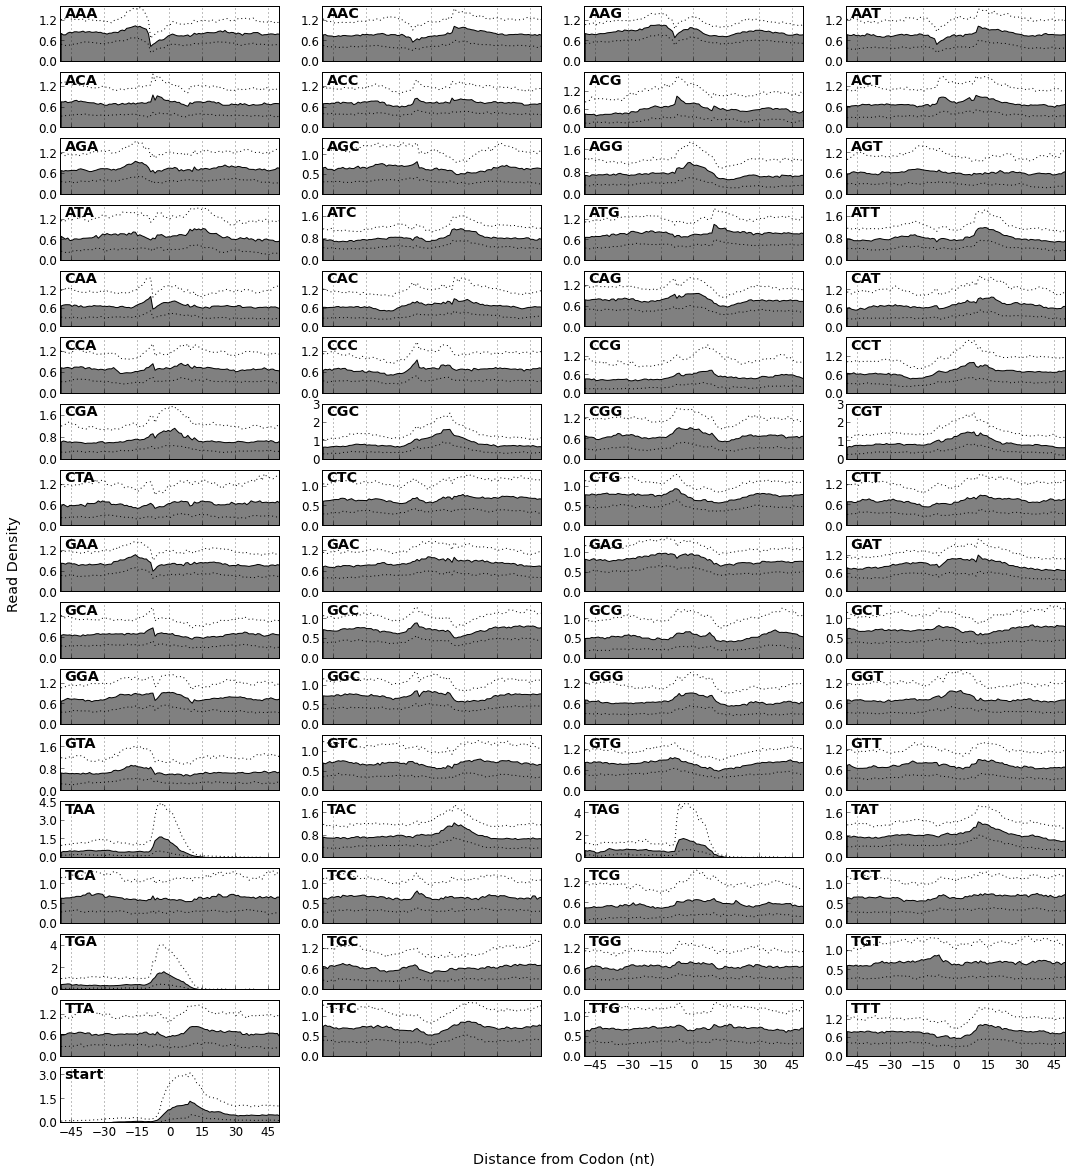

In [68]:
import cPickle as pickle

sample = "5"
offset = 50   

import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator, NullLocator, MaxNLocator
from Bio.SeqUtils import CodonUsage

codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
    codon_number_dict[codon] = codon_number
codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Liberation Sans'
plt.rcParams['font.size'] = 12

fig = plt.figure()
common_ax = plt.axes(frameon=False)
common_ax.set_xlabel('Distance from Codon (nt)', fontsize = "larger")
common_ax.set_ylabel(r'Read Density', fontsize = "larger")
common_ax.set_xticks([])
common_ax.set_yticks([])
common_ax.yaxis.labelpad = 40
common_ax.xaxis.labelpad = 30

sampleStats = pickle.load( open('processedDataFiles/HelaDataAug2013_Rasi293TdataFeb2013/sampleStats_monosomes_5.pickled'))

for codonIndex, codon in enumerate( sorted( codon_number_dict ) ):
    x_vector = numpy.arange(-offset,+offset+1)
    ax = fig.add_subplot(17,4,codonIndex+1)
    plt.fill_between(x_vector, sampleStats['codonRibosomeOccupancyMedian'][codon][offset+50:+offset+150+1],        
        edgecolor = 'black', facecolor = 'grey' );
    plt.plot(x_vector, sampleStats['codonRibosomeOccupancy25'][codon][offset+50:+offset+150+1], ":k");
    plt.plot(x_vector, sampleStats['codonRibosomeOccupancy75'][codon][offset+50:+offset+150+1], ":k");    
    ax.set_title(codon, x=0.02, y=0.7, ha = 'left', fontweight="bold");
    if codonIndex < 62:
        ax.xaxis.set_ticklabels([])
    ax.xaxis.set_major_locator(MaxNLocator(8))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_locator(MaxNLocator(3, prune=None))
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-offset,+offset)#plt.ylim((0,max([plt.ylim()[1],2])));
    ax.xaxis.grid()
fig.set_size_inches([18,20])

#this is a series of 64 plots of the ribosome occupancy (normalized occupancy counts) across all possible codons - look from a certain offet ,
#also the dotted lines are quartile boundaries (75% of the data falls under top line, for example). Can change the sample, the offset, *make sure the locations of the 
#pickled file in sampleStats is correct. If the offset is changed, make the corresponding change later in the codon [never change x_vector, just change offset and adjust scale when plotting with plt. ]

/Applications/Canopy.app/appdata/canopy-1.0.0.1160.macosx-x86/Canopy.app/Contents/lib/python2.7/site-packages/matplotlib/font_manager.py:1214: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


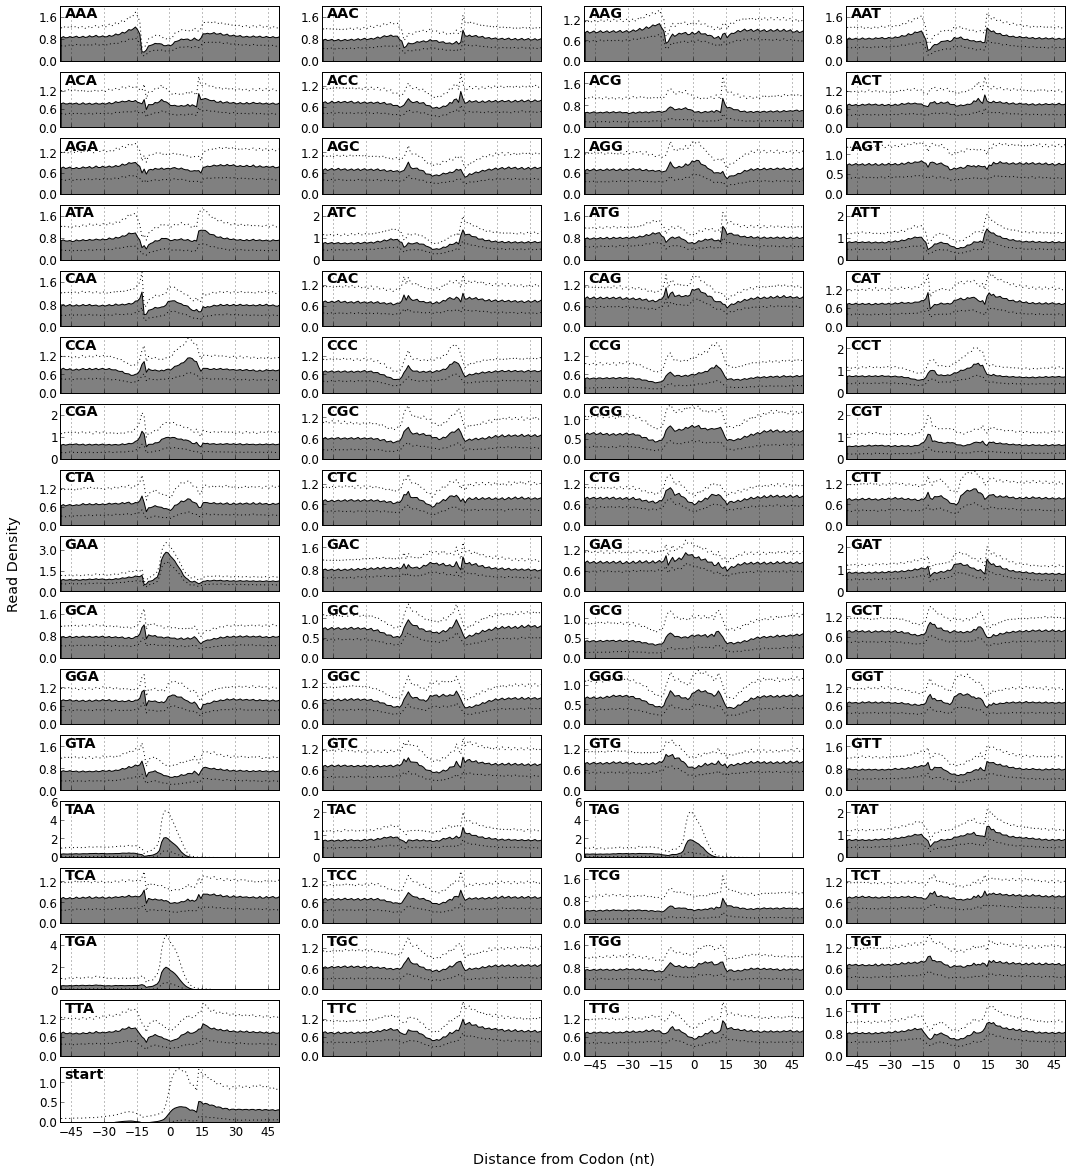

In [35]:
import cPickle as pickle

sample = "gfp_rich"
offset = 50   

import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator, NullLocator, MaxNLocator
from Bio.SeqUtils import CodonUsage

codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
    codon_number_dict[codon] = codon_number
codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Liberation Sans'
plt.rcParams['font.size'] = 12

fig = plt.figure()
common_ax = plt.axes(frameon=False)
common_ax.set_xlabel('Distance from Codon (nt)', fontsize = "larger")
common_ax.set_ylabel(r'Read Density', fontsize = "larger")
common_ax.set_xticks([])
common_ax.set_yticks([])
common_ax.yaxis.labelpad = 40
common_ax.xaxis.labelpad = 30

sampleStats = pickle.load( open('processedDataFiles/20140829_293T_q99ltorin/sampleStats293_gfp_rich.pickled'))

for codonIndex, codon in enumerate( sorted( codon_number_dict ) ):
    x_vector = numpy.arange(-offset,+offset+1)
    ax = fig.add_subplot(17,4,codonIndex+1)
    plt.fill_between(x_vector, sampleStats['codonRibosomeOccupancyMedian'][codon][offset+50:+offset+150+1],        
        edgecolor = 'black', facecolor = 'grey' );
    plt.plot(x_vector, sampleStats['codonRibosomeOccupancy25'][codon][offset+50:+offset+150+1], ":k");
    plt.plot(x_vector, sampleStats['codonRibosomeOccupancy75'][codon][offset+50:+offset+150+1], ":k");    
    ax.set_title(codon, x=0.02, y=0.7, ha = 'left', fontweight="bold");
    if codonIndex < 62:
        ax.xaxis.set_ticklabels([])
    ax.xaxis.set_major_locator(MaxNLocator(8))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_locator(MaxNLocator(3, prune=None))
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-offset,+offset)#plt.ylim((0,max([plt.ylim()[1],2])));
    ax.xaxis.grid()
fig.set_size_inches([18,20])
fig.savefig( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/pausing_plots/allcodons_gfprich.pdf' )
#this is a series of 64 plots of the ribosome occupancy (normalized occupancy counts) across all possible codons - look from a certain offet ,
#also the dotted lines are quartile boundaries (75% of the data falls under top line, for example). Can change the sample, the offset, *make sure the locations of the 
#pickled file in sampleStats is correct. If the offset is changed, make the corresponding change later in the codon [never change x_vector, just change offset and adjust scale when plotting with plt. ]

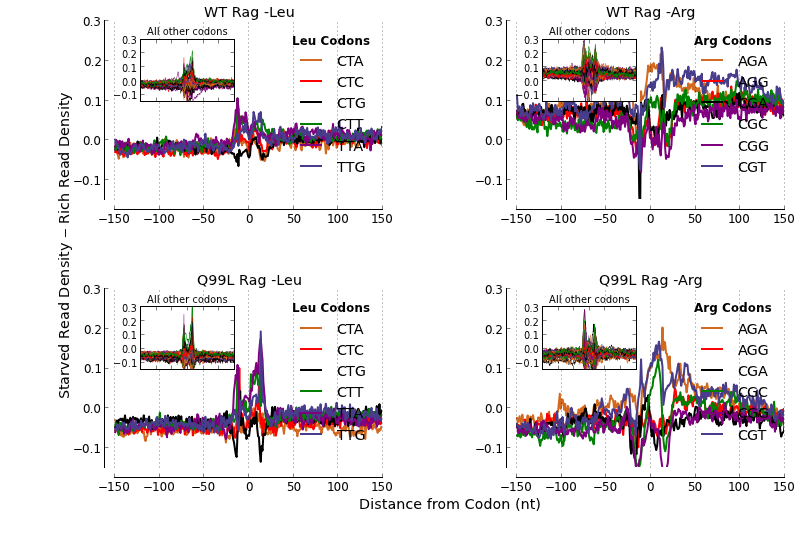

In [76]:
#plot starved-rich ribosome occupancy changes at any codon family

import cPickle as pickle

top_samples = ['wtrag_leu','wtrag_arg','q99lrag_leu','q99lrag_arg']
bottom_samples = ['wtrag_rich','wtrag_rich','q99lrag_rich','q99lrag_rich']

offset = 150

import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator, NullLocator, MaxNLocator
from Bio.SeqUtils import CodonUsage
from matplotlib.transforms import Bbox


codon_number_dict = CodonUsage.CodonsDict.copy() # create local copy of codon dictionary.
    
for codon_number, codon in enumerate( sorted( codon_number_dict ) ):
    codon_number_dict[codon] = codon_number
codon_number_dict["start"] = 64 # assign numbers to different codons alphabetically.

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Liberation Sans'
plt.rcParams['font.size'] = 12

fig = plt.figure()
common_ax = plt.axes(frameon=False)
common_ax.set_xlabel('Distance from Codon (nt)', fontsize = "larger")
common_ax.set_ylabel(r'Starved Read Density $\minus$ Rich Read Density', fontsize = "larger")
common_ax.set_xticks([])
common_ax.set_yticks([])
common_ax.yaxis.labelpad = 40
common_ax.xaxis.labelpad = 30

fig.subplots_adjust( wspace=0.5, hspace=0.5 )

edge_colors = ["chocolate", "red", "black", "green", "purple", "darkslateblue"]
summedDensity = dict()
stallingIndex = dict()
for sampleIndex, sample in enumerate( top_samples ):
    sampleStats_top = pickle.load( open( 'processedDataFiles/20140829_293T_q99ltorin/sampleStats293_' + top_samples[sampleIndex] + '.pickled', 'rb' ) )
    sampleStats_bottom = pickle.load( open( 'processedDataFiles/20140829_293T_q99ltorin/sampleStats293_' + bottom_samples[sampleIndex] + '.pickled', 'rb' ) )
    
    summedDensity[top_samples[sampleIndex]] = dict()    
    if re.search( 'wtrag_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = 'WT Rag -Leu'
    elif re.search( 'wtrag_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = 'WT Rag -Arg'
    elif re.search( 'q99lrag_leu', top_samples[sampleIndex] ):
        subsetCodons = ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA']
        legendTitle = 'Leu Codons'
        axTitle = 'Q99L Rag -Leu'
    elif re.search( 'q99lrag_arg', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = 'Q99L Rag -Arg'
    elif re.search( '293_F_mono', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = 'Torin1, -Arginine'
    elif re.search( '293_G_mono', top_samples[sampleIndex] ):
        subsetCodons = ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT']
        legendTitle = 'Arg Codons'
        axTitle = '-Leucine, Torin1, -Arginine'
        
    
    ax = fig.add_subplot( int(numpy.ceil(len(top_samples)/2.0)),2,sampleIndex+1)     
    temp = list()
    
    for codonIndex, codon in enumerate( sorted( filter( lambda codon: codon in subsetCodons, codon_number_dict ) ) ):
        x_vector = numpy.arange(-offset,+offset+1)
        y_vector = sampleStats_top['codonRibosomeOccupancyMedian'][codon] - sampleStats_bottom['codonRibosomeOccupancyMedian'][codon]
        
        ax.plot(x_vector, y_vector, color = edge_colors[codonIndex], label=codon, linewidth=2, marker=None);        
        #print sample, codon, y_vector[offset-30:offset+50].sum() - min(temp) + 1    
    
    for loc, spine in ax.spines.items():
        if loc in ['left','bottom']:
            spine.set_position(('outward',10)) # outward by 10 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)

    # turn off ticks where there is no spine
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_major_locator(MaxNLocator(7))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(bottom=-0.15, top=.3)
    ax.yaxis.set_major_locator(MaxNLocator(5, prune=None))
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-offset,+offset)
    ax.xaxis.grid()
    
    ax.set_title( axTitle )
    temp = ax.legend(frameon=False, title=legendTitle)
    temp.get_title().set_fontweight( 'bold' )
    
    bboxvalues = ax.get_position().get_points()
    left = bboxvalues[0,0] + 0.03
    bottom = bboxvalues[0,1] + 0.17  #adjust this value if the height of the box is off-- higher makes it go up relative to its plot and lower makes it go down.
    width = 0.35* ( bboxvalues[1,0]-bboxvalues[0,0] )
    height = 0.35* ( bboxvalues[1,1]-bboxvalues[0,1] )
    
    ax2 = fig.add_axes([left,bottom,width,height])
    
    for codonIndex, codon in enumerate( sorted( filter( lambda codon: codon not in subsetCodons, codon_number_dict ) ) ):
        x_vector = numpy.arange(-offset,+offset+1)
        
        if codon in ['TGA','TAA','TAG','start']:
            continue
        yvector = sampleStats_top['codonRibosomeOccupancyMedian'][codon] - sampleStats_bottom['codonRibosomeOccupancyMedian'][codon]
        
        
        ax2.plot(x_vector, yvector,    
            color = edge_colors[numpy.mod(codonIndex,6)], label=codon, linewidth=0.5, marker=None);
        
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    [i.set_fontsize( 'small' ) for i in ax2.get_yticklabels()]
    ax2.xaxis.set_major_locator(ax.xaxis.get_major_locator())    
    ax2.yaxis.set_major_locator(ax.yaxis.get_major_locator())    
    ax2.xaxis.set_ticklabels([])
    #ax2.yaxis.set_ticklabels([])
    ax2.set_title( 'All other codons', fontsize='small')  
    
fig.set_size_inches([12,4 * numpy.ceil(len(top_samples)/2.0)])
#fig.savefig( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/pausing_plots/ragwtleuarg_q99lleuarg_vsrich.pdf' )

[None]

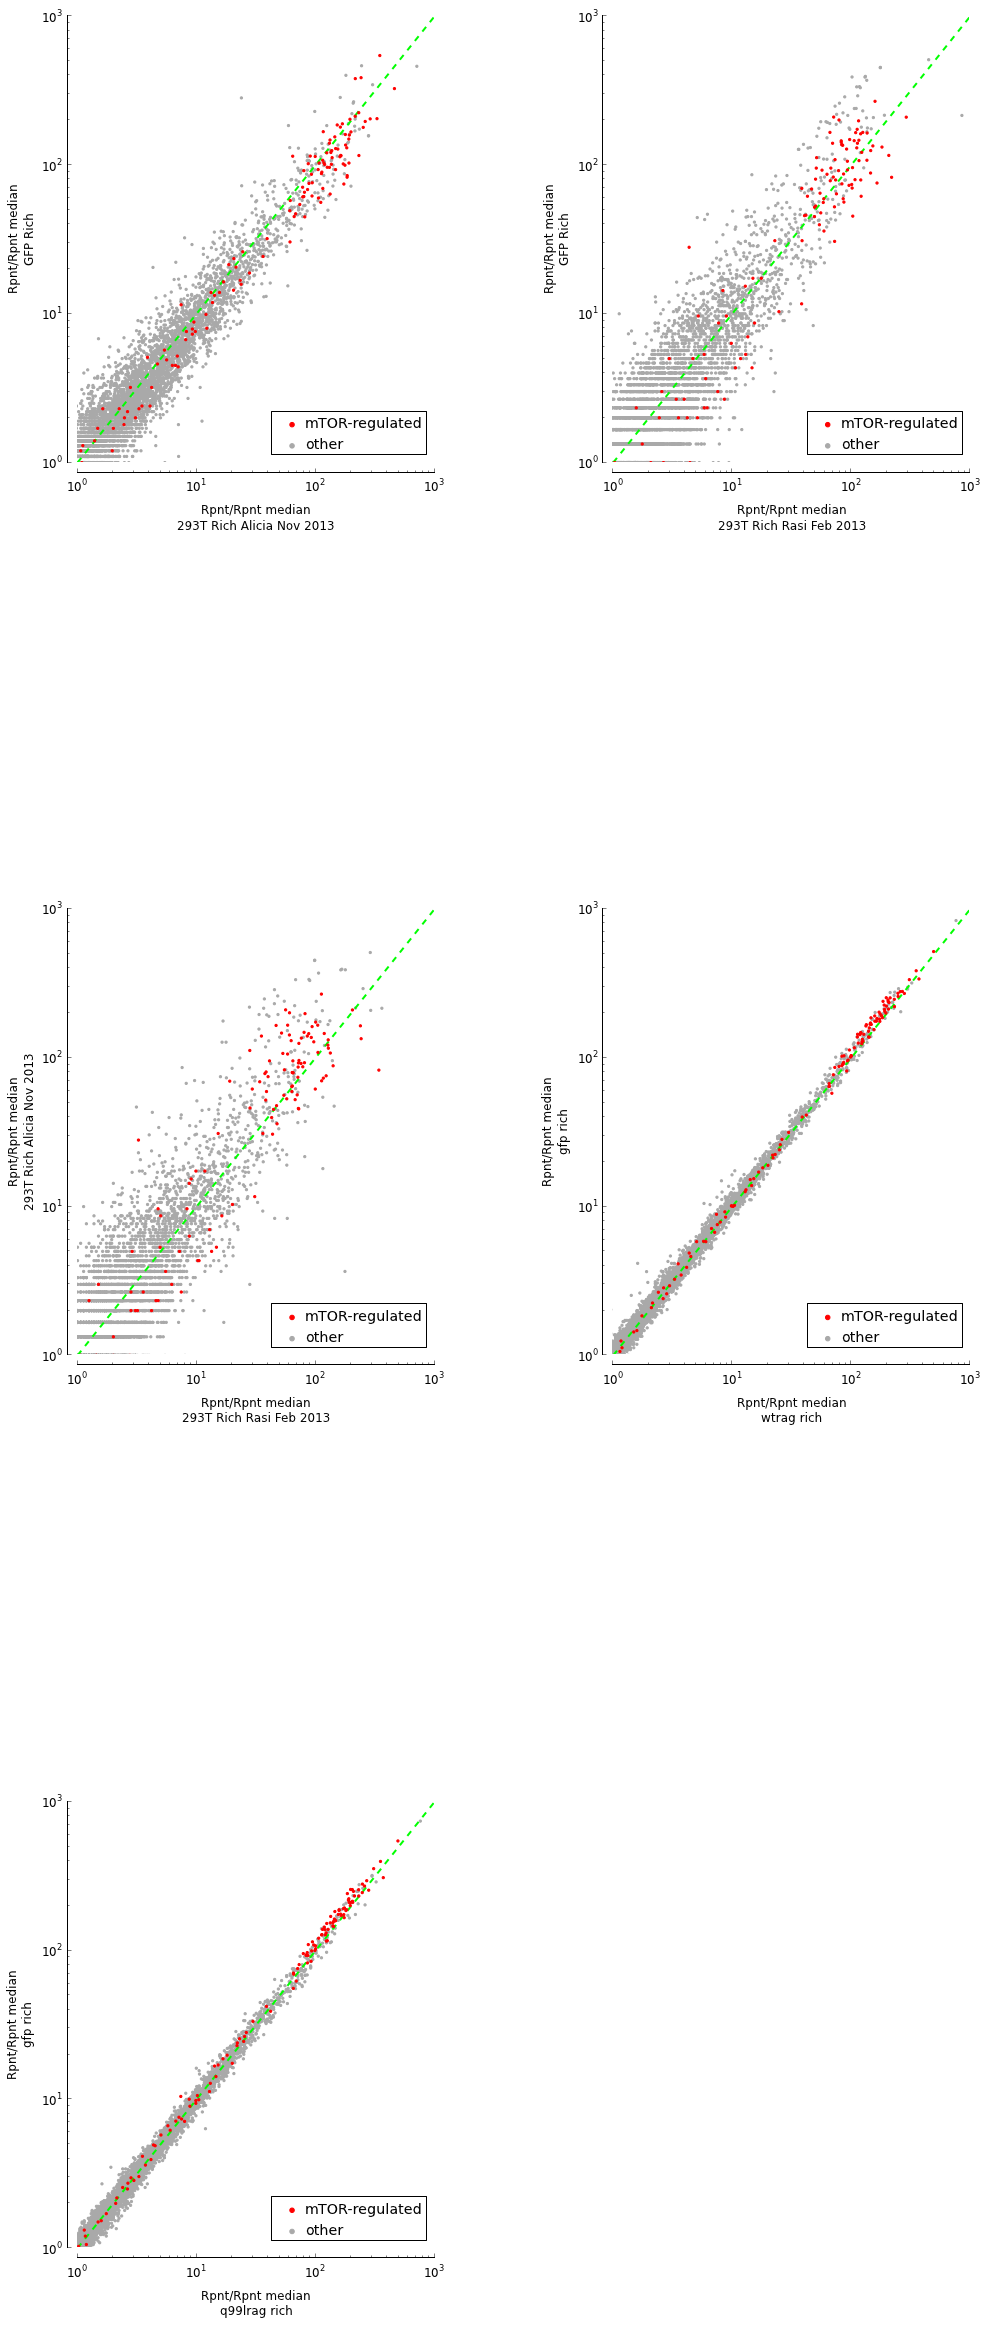

In [48]:
#this code plots differences in translational efficiency in leu vs rich, arg vs rich, and leu vs arg. Outliers may be the pp242 genes, or the top x targets of mTOR inhibition at the level of translational repression.
#goes through x samples one by one and matches it up with the corresponding ySample (I guess this way we only have to iterate through one list, xSamples.
#this needs to be run from a directory containing pp242.csv or change the file path.


from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines

xSamples = [ 'gfp_rich','gfp_rich','A_mono','gfp_rich','gfp_rich'
            ]
ySamples = [ 'A_mono','monosomes_rich293','monosomes_rich293','wtrag_rich','q99lrag_rich'
            ]

yLabels = [ 'GFP Rich','GFP Rich','293T Rich Alicia Nov 2013','gfp rich' ,'gfp rich']
xLabels = [ '293T Rich Alicia Nov 2013','293T Rich Rasi Feb 2013','293T Rich Rasi Feb 2013','wtrag rich','q99lrag rich']

numberOfPlotsPerLine = 2

fig = plt.figure()

pp242_regulated_genes = list( pandas.read_csv( 'pp242_downregulated_genes.csv' )['refseq'] )

for sampleNumber, xSample in enumerate( xSamples ): 
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
        #conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
        
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
            
    xVector = (data[ 'rpnt_' + xSample ][ subset ])
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ] )
    xMedian = numpy.median(xVector)
    yMedian = numpy.median(yVector)
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
    conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'rpnt_' + xSample ][ subset ]) / xMedian
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ]) / yMedian      
    
    ax = fig.add_subplot( len( xSamples) / numberOfPlotsPerLine + 1, numberOfPlotsPerLine, sampleNumber + 1 )    
    ax.scatter( xVector, yVector, marker='.', color = 'red', label='mTOR-regulated', zorder=15 )
    
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
    conditions.append( numpy.logical_not( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) )    
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'rpnt_' + xSample ][ subset ]) / xMedian
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ]) / yMedian   
    
    ax.scatter( xVector, yVector, marker='.', color = 'darkgrey', label='other' )
    
    [ spine.set_position(('outward',10)) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ]    
    
    ax.xaxis.set( ticks_position = 'bottom', major_locator = MaxNLocator(6) )
    ax.yaxis.set( ticks_position = 'left', major_locator = MaxNLocator(6) )
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set( xlabel = 'Rpnt/Rpnt median \n' + xLabels[ sampleNumber ] ,  xlim = (1,1000), ylim=(1,1000) )
    ax.add_line( mlines.Line2D( (1, 1000), (1, 1000), linewidth=2, linestyle='dashed', color='lime', zorder=10 ) )
    ax.set_ylabel( 'Rpnt/Rpnt median \n' +  yLabels[ sampleNumber ] ,ha='center' )
    ax.xaxis.labelpad = 10    
    ax.yaxis.labelpad = 20
    temp = ax.legend(loc='lower right', scatterpoints=1, markerscale=2, handletextsep=0)
    
fig.subplots_adjust( hspace = 1, wspace = 0.5 )
fig.set( size_inches = [ 8 * numberOfPlotsPerLine, 16 * len( xSamples) / numberOfPlotsPerLine ] );
#fig.savefig( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/geneexp_foldchange_plots/rpnt_gfprich_vsboth_rich293Rasi_Amonorich293.pdf')

# needed to subtract the x and y medians from each data point since xVector and yVector had slightly different median values

In [190]:
print numpy.median(data['rpnt_gfp_rich'])
numpy.median(data['rpnt_gfp_leu'])
print numpy.median(data['rpnt_monosomes_rich293'])

0.42
0.02


In [49]:
len(xVector)
len(yVector)

10785

In [201]:
#temp = data[subset]
HTML( data[ numpy.logical_and((data['rpnt_gfp_rich']/numpy.median(data['rpnt_gfp_rich']) > 100), (data['rpnt_monosomes_rich293']/numpy.median(data['rpnt_monosomes_rich293']) < 50)) ].sort(columns=['rpnt_gfp_rich'],ascending=False).to_html() )

,refseqid,rpnt_A_mono,end,start,length,counts_A_mono,counts_gfp_arg,rpnt_gfp_arg,counts_gfp_leu,rpnt_gfp_leu,counts_gfp_rich,rpnt_gfp_rich,counts_gfp_torin_arg,rpnt_gfp_torin_arg,counts_gfp_torin_leu,rpnt_gfp_torin_leu,counts_gfp_torin_rich,rpnt_gfp_torin_rich,counts_monosomes_arg293,rpnt_monosomes_arg293,counts_monosomes_leu293,rpnt_monosomes_leu293,counts_monosomes_rich293,rpnt_monosomes_rich293,counts_q99lrag_arg,rpnt_q99lrag_arg,counts_q99lrag_leu,rpnt_q99lrag_leu,counts_q99lrag_rich,rpnt_q99lrag_rich,counts_wtrag_arg,rpnt_wtrag_arg,counts_wtrag_leu,rpnt_wtrag_leu,counts_wtrag_rich,rpnt_wtrag_rich,description,fc_gfprich_over_gfparg,subset_counts_gfp_rich,subset_counts_gfp_leu,subset_counts_gfp_arg,subset_counts_gfp_torin_rich,subset_counts_gfp_torin_leu,subset_counts_gfp_torin_arg,subset_counts_wtrag_rich,subset_counts_wtrag_leu,subset_counts_wtrag_arg,subset_counts_q99lrag_rich,subset_counts_q99lrag_leu,subset_counts_q99lrag_arg,subset_counts_monosomes_rich293,subset_counts_monosomes_leu293,subset_counts_monosomes_arg293,fc_gfprich_over_gfparg_mediannormal,fc_gfprich_over_gfpleu,fc_wtragrich_over_wtragleu,fc_wtrag_rich,fc_q99lragrich_over_q99lragleu,fc_q99lragrich_over_q99lragarg,fc_wtragrich_over_q99lragarg,fc_wtragrich_over_wtragarg,fc_wtragrich_over_q99lragrich,fc_wtragleu_over_q99lragleu,fc_wtragarg_over_q99lragarg,fc_gfprich_over_wtragrich,fc_gfprich_over_q99lragrich,fc_gfpleu_over_wtragleu,fc_gfparg_over_wtragarg
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RPL22,NM_000983.3,6.96,433,46,387,2695,7852,20.29,13474,34.82,20468,52.89,943,2.44,832,2.15,725,1.87,433,1.12,255,0.66,357,0.92,8663,22.39,14695,37.97,15248,39.40,11175,28.88,11602,29.98,15881,41.04,"ribosomal protein L22 (RPL22), mRNA.",0.69,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.745443,0.675705,0.313306,0,0.011138,-0.015508,0.422963,0.422963,0.136684,-0.165484,-0.301787,-0.036438,0.100245,-0.398837,-0.358919
CALM2,NM_001743.4,5.75,608,158,450,2587,10736,23.86,16269,36.15,21672,48.16,2655,5.90,2659,5.91,2767,6.15,375,0.83,472,1.05,409,0.91,7430,16.51,13364,29.70,13690,30.42,11383,25.29,11307,25.13,13806,30.68,"calmodulin 2 (phosphorylase kinase, delta) (CA...",0.32,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.376581,0.486220,0.148457,0,-0.007386,0.050499,0.194350,0.194350,0.090175,-0.065668,-0.053676,0.248030,0.338205,-0.089732,0.065800
cytosolic,NM_001017963.2,7.72,2910,345,2565,19806,66880,26.07,110829,43.21,111330,43.40,16937,6.60,15649,6.10,14783,5.76,3002,1.17,3166,1.23,1694,0.66,49492,19.29,87685,34.19,86714,33.81,76974,30.01,77225,30.11,79654,31.05,"heat shock protein 90kDa alpha (cytosolic), cl...",0.04,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0.098401,0.079020,-0.094943,0,-0.058222,-0.022119,-0.034689,-0.034689,-0.044516,-0.007795,-0.031947,0.080517,0.036001,-0.093446,-0.052572


,refseqid,rpnt_A_mono,end,start,length,counts_A_mono,counts_gfp_arg,rpnt_gfp_arg,counts_gfp_leu,rpnt_gfp_leu,counts_gfp_rich,rpnt_gfp_rich,counts_gfp_torin_arg,rpnt_gfp_torin_arg,counts_gfp_torin_leu,rpnt_gfp_torin_leu,counts_gfp_torin_rich,rpnt_gfp_torin_rich,counts_monosomes_arg293,rpnt_monosomes_arg293,counts_monosomes_leu293,rpnt_monosomes_leu293,counts_monosomes_rich293,rpnt_monosomes_rich293,counts_q99lrag_arg,rpnt_q99lrag_arg,counts_q99lrag_leu,rpnt_q99lrag_leu,counts_q99lrag_rich,rpnt_q99lrag_rich,counts_wtrag_arg,rpnt_wtrag_arg,counts_wtrag_leu,rpnt_wtrag_leu,counts_wtrag_rich,rpnt_wtrag_rich,description,fc_gfprich_over_gfparg,subset_counts_gfp_rich,subset_counts_gfp_leu,subset_counts_gfp_arg,subset_counts_gfp_torin_rich,subset_counts_gfp_torin_leu,subset_counts_gfp_torin_arg,subset_counts_wtrag_rich,subset_counts_wtrag_leu,subset_counts_wtrag_arg,subset_counts_q99lrag_rich,subset_counts_q99lrag_leu,subset_counts_q99lrag_arg,subset_counts_monosomes_rich293,subset_counts_monosomes_leu293,subset_counts_monosomes_arg293,fc_gfprich_over_gfparg_mediannormal
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FLJ44635,NM_207422.2,0.18,771,348,423,76,216,0.51,729,1.72,1371,3.24,39,0.09,50,0.12,27,0.06,19,0.04,11,0.03,27,0.06,247,0.58,1114,2.63,855,2.02,347,0.82,668,1.58,1090,2.58,"TPT1-like protein (FLJ44635), mRNA.",1.97,True,True,True,False,False,False,True,True,True,True,True,True,False,False,False,2.029330
FBXO9,NM_012347.4,0.16,1395,51,1344,220,124,0.09,520,0.39,693,0.52,170,0.13,155,0.12,171,0.13,4,0.00,8,0.01,20,0.01,93,0.07,320,0.24,478,0.36,128,0.10,354,0.26,495,0.37,"F-box protein 9 (FBXO9), transcript variant 1,...",1.79,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,1.845720
HSPA1B,NM_005346.4,2.12,2142,216,1926,4086,2388,1.24,8127,4.22,11297,5.87,328,0.17,233,0.12,323,0.17,148,0.08,283,0.15,1341,0.70,1804,0.94,8486,4.41,11908,6.18,2576,1.34,6574,3.41,9596,4.98,"heat shock 70kDa protein 1B (HSPA1B), mRNA.",1.55,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.605270
HSPA1A,NM_005345.5,1.77,2169,243,1926,3413,1855,0.96,6598,3.43,8772,4.55,247,0.13,201,0.10,243,0.13,142,0.07,227,0.12,1042,0.54,1558,0.81,6755,3.51,9693,5.03,1975,1.03,5253,2.73,7276,3.78,"heat shock 70kDa protein 1A (HSPA1A), mRNA.",1.55,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.604692
HSPA2,NM_021979.3,0.05,2302,382,1920,88,92,0.05,325,0.17,416,0.22,15,0.01,12,0.01,10,0.01,2,0.00,4,0.00,17,0.01,39,0.02,210,0.11,317,0.17,84,0.04,218,0.11,277,0.14,"heat shock 70kDa protein 2 (HSPA2), mRNA.",1.48,True,True,False,False,False,False,True,True,False,True,True,False,False,False,False,1.540083
MTRNR2L4,NM_001190476.1,57.66,468,381,87,5016,12187,140.08,54215,623.16,53966,620.30,3737,42.95,3301,37.94,9541,109.67,422,4.85,421,4.84,562,6.46,9172,105.43,28178,323.89,41702,479.33,11350,130.46,27995,321.78,20772,238.76,"MT-RNR2-like 4 (MTRNR2L4), mRNA.",1.45,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.509913
HSPA1L,NM_005527.3,0.05,2109,183,1926,102,56,0.03,161,0.08,237,0.12,13,0.01,2,0.00,7,0.00,5,0.00,4,0.00,22,0.01,60,0.03,200,0.10,252,0.13,72,0.04,136,0.07,215,0.11,"heat shock 70kDa protein 1-like (HSPA1L), mRNA.",1.39,True,True,False,False,False,False,True,True,False,True,True,False,False,False,False,1.444593
PTMS,NM_002824.4,1.26,640,331,309,391,522,1.69,890,2.88,1917,6.20,106,0.34,112,0.36,170,0.55,98,0.32,75,0.24,85,0.27,482,1.56,679,2.20,1207,3.91,446,1.44,493,1.60,1098,3.55,"parathymosin (PTMS), mRNA.",1.18,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,1.239934
NACA2,NM_199290.3,0.80,670,22,648,518,1606,2.48,2781,4.29,5736,8.85,295,0.46,246,0.38,287,0.44,127,0.20,103,0.16,127,0.20,1296,2.00,2723,4.20,3283,5.07,1670,2.58,2411,3.72,4074,6.29,nascent polypeptide-associated complex alpha s...,1.14,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.199778


In [132]:
temp = data[subset]
HTML( temp[ numpy.logical_and( temp['fc_monosomesleu293_over_gfpleu'] < 0, temp['counts_monosomes_leu293'] > 100) ].sort(columns=['rpnt_gfp_leu'],ascending=True).to_html() )

KeyError: u'no item named fc_monosomesleu293_over_gfpleu'

In [62]:
sample = 'gfp_rich'

import pandas

sampleStats = pickle.load( open( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/sampleStats293_' + sample + '.pickled', 'rb' ) )
genes = pickle.load( open( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/geneStats293_' + sample + '.pickled', 'rb' ) )
genesDF = pandas.DataFrame.from_dict( genes, orient='index' )

HTML( genesDF.sort(columns='readDensityPerNt', ascending=False)[:400].to_html() )

,readDensityPerNt,end,seq,start,totalCountsTranscript,length,totalCountsCds
NM_001190476.1,620.298851,468,"(A, T, G, G, C, C, A, C, A, C, A, A, G, G, G, ...",381,53978,87,53966.000000
NM_021104.1,326.091851,161,"(A, T, G, A, G, A, G, C, C, A, A, G, T, G, G, ...",83,25733,78,25435.164395
NM_001000.2,259.424250,223,"(A, T, G, T, C, T, T, C, T, C, A, C, A, A, G, ...",67,41605,156,40470.182961
NM_001402.5,211.369041,1452,"(A, T, G, G, G, A, A, A, G, G, A, A, A, A, G, ...",63,293631,1389,293591.597983
NM_002520.6,159.248305,1130,"(A, T, G, G, A, A, G, A, T, T, C, G, A, T, G, ...",245,140957,885,140934.750000
NM_001032.3,154.555556,201,"(A, T, G, G, G, T, C, A, C, C, A, G, C, A, G, ...",30,26429,171,26429.000000
NM_000987.3,150.837900,534,"(A, T, G, A, A, G, T, T, T, A, A, T, C, C, C, ...",96,66067,438,66067.000000
NM_021130.3,138.569196,581,"(A, T, G, G, T, C, A, A, C, C, C, C, A, C, C, ...",83,69060,498,69007.459380
NM_001007.4,132.178030,888,"(A, T, G, G, C, T, C, G, T, G, G, T, C, C, C, ...",96,104685,792,104685.000000
NM_001034077.4,128.176282,340,"(A, T, G, T, C, C, G, G, C, A, G, A, G, G, A, ...",28,39991,312,39991.000000


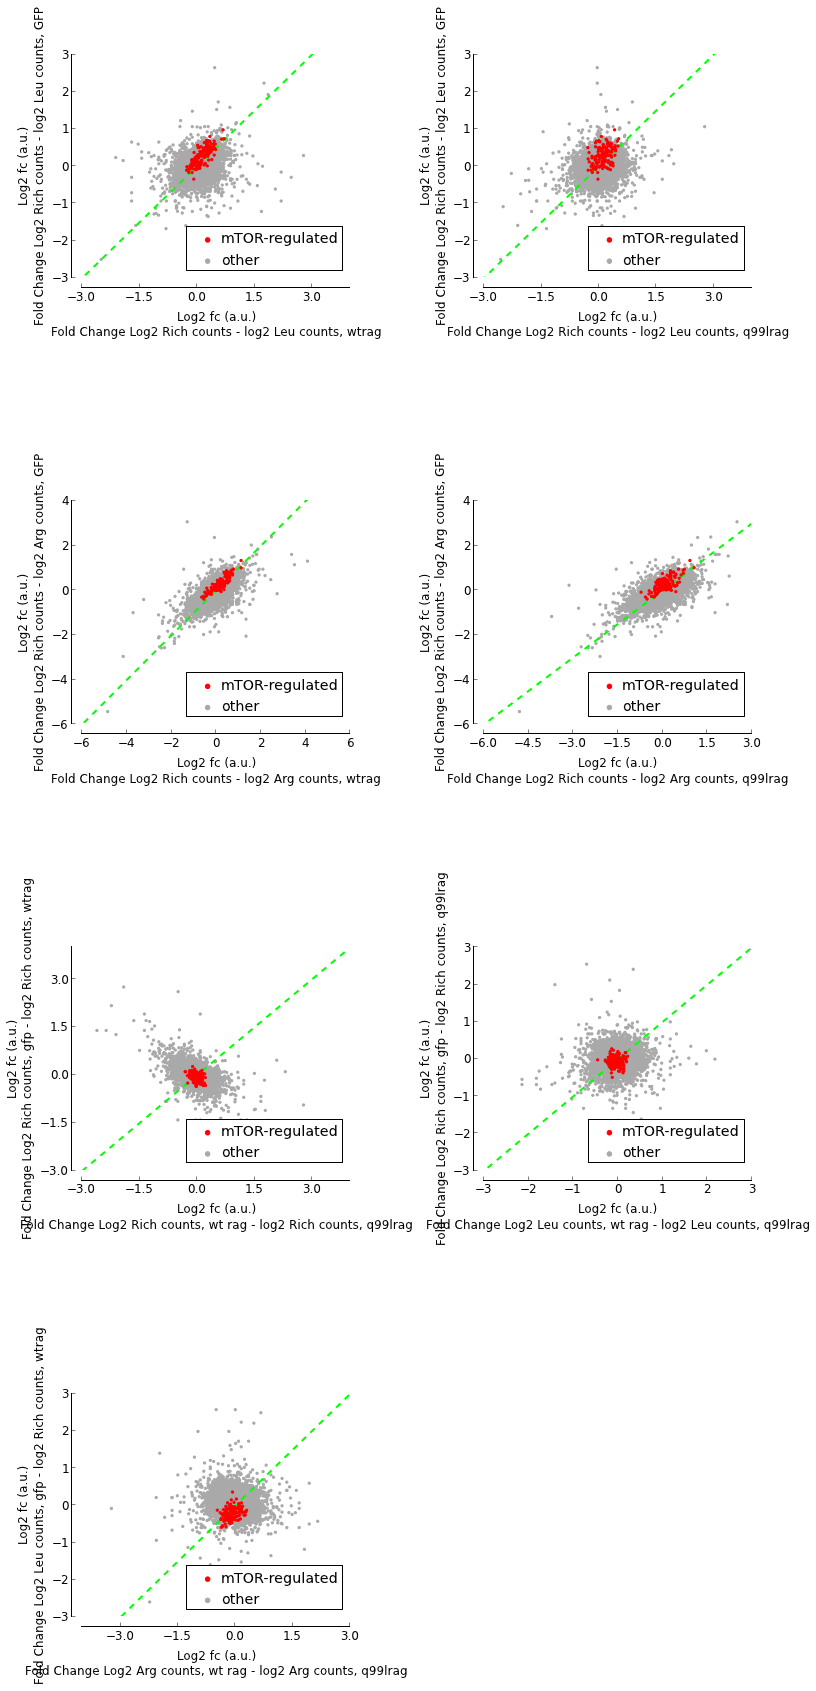

In [175]:
#this code plots differences in translational efficiency in leu vs rich, arg vs rich, and leu vs arg. Outliers may be the pp242 genes, or the top x targets of mTOR inhibition at the level of translational repression.
#goes through x samples one by one and matches it up with the corresponding ySample (I guess this way we only have to iterate through one list, xSamples.
#this needs to be run from a directory containing pp242.csv or change the file path.


from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines

xSamples = [ 'wtragrich_over_wtragleu','q99lragrich_over_q99lragleu','wtragrich_over_wtragarg','q99lragrich_over_q99lragarg','wtragrich_over_q99lragrich','wtragleu_over_q99lragleu','wtragarg_over_q99lragarg'
            ]
ySamples = [ 'gfprich_over_gfpleu','gfprich_over_gfpleu','gfprich_over_gfparg','gfprich_over_gfparg','gfprich_over_wtragrich','gfprich_over_q99lragrich','gfpleu_over_wtragleu','gfparg_over_wtragarg'
            ]

xLabels = [ 'Fold Change Log2 Rich counts - log2 Leu counts, wtrag' ,'Fold Change Log2 Rich counts - log2 Leu counts, q99lrag', 'Fold Change Log2 Rich counts - log2 Arg counts, wtrag' ,'Fold Change Log2 Rich counts - log2 Arg counts, q99lrag','Fold Change Log2 Rich counts, wt rag - log2 Rich counts, q99lrag', 'Fold Change Log2 Leu counts, wt rag - log2 Leu counts, q99lrag', 'Fold Change Log2 Arg counts, wt rag - log2 Arg counts, q99lrag' ]
yLabels = [ 'Fold Change Log2 Rich counts - log2 Leu counts, GFP','Fold Change Log2 Rich counts - log2 Leu counts, GFP','Fold Change Log2 Rich counts - log2 Arg counts, GFP','Fold Change Log2 Rich counts - log2 Arg counts, GFP','Fold Change Log2 Rich counts, gfp - log2 Rich counts, wtrag','Fold Change Log2 Rich counts, gfp - log2 Rich counts, q99lrag','Fold Change Log2 Leu counts, gfp - log2 Rich counts, wtrag','Fold Change Log2 Arg counts, gfp - log2 Arg counts, wtrag']

numberOfPlotsPerLine = 2

fig = plt.figure()

pp242_regulated_genes = list( pandas.read_csv( 'pp242_downregulated_genes.csv' )['refseq'] )

for sampleNumber, xSample in enumerate( xSamples ): 
    conditions = []
    conditions.append( data[ 'fc_' + xSample ]  )
    conditions.append( data[ 'fc_' + ySamples[ sampleNumber ] ] )    
        #conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
        
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
            
    xVector = (data[ 'fc_' + xSample ][ subset ])
    yVector = (data[ 'fc_' + ySamples[ sampleNumber ] ][ subset ] )
    xMedian = numpy.median(xVector)
    yMedian = numpy.median(yVector)
    conditions = []
    conditions.append( data[ 'fc_' + xSample ]  )
    conditions.append( data[ 'fc_' + ySamples[ sampleNumber ] ] )    
    conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'fc_' + xSample ][ subset ]) - xMedian
    yVector = (data[ 'fc_' + ySamples[ sampleNumber ] ][ subset ]) - yMedian      
    
    ax = fig.add_subplot( len( xSamples) / numberOfPlotsPerLine + 1, numberOfPlotsPerLine, sampleNumber + 1 )    
    ax.scatter( xVector, yVector, marker='.', color = 'red', label='mTOR-regulated', zorder=15 )
    
    conditions = []
    conditions.append( data[ 'fc_' + xSample ]  )
    conditions.append( data[ 'fc_' + ySamples[ sampleNumber ] ] )    
    conditions.append( numpy.logical_not( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) )    
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'fc_' + xSample ][ subset ]) - xMedian
    yVector = (data[ 'fc_' + ySamples[ sampleNumber ] ][ subset ]) - yMedian   
    
    ax.scatter( xVector, yVector, marker='.', color = 'darkgrey', label='other' )
    
    [ spine.set_position(('outward',10)) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ]    
    
    ax.xaxis.set( ticks_position = 'bottom', major_locator = MaxNLocator(6) )
    ax.yaxis.set( ticks_position = 'left', major_locator = MaxNLocator(6) )
    ax.set( xlabel = 'Log2 fc (a.u.)\n' + xLabels[ sampleNumber ] ) #,  xlim = (-1,5), ylim=(-1,5) )
    ax.add_line( mlines.Line2D( (-120, +120), (-120, +120), linewidth=2, linestyle='dashed', color='lime', zorder=10 ) )
    ax.set_ylabel( 'Log2 fc (a.u.)\n' +  yLabels[ sampleNumber ] ,ha='center' )
    ax.xaxis.labelpad = 10    
    ax.yaxis.labelpad = 20
    temp = ax.legend(loc='lower right', scatterpoints=1, markerscale=2, handletextsep=0)
    
fig.subplots_adjust( hspace = 1, wspace = 0.5 )
fig.set( size_inches = [ 6 * numberOfPlotsPerLine, 8 * len( xSamples) / numberOfPlotsPerLine ] );
fig.savefig( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/geneexp_foldchange_plots/foldchangegfprichoverleu_vs_wtragrichoverleu_or_q99lragrichoverleu_andarg.pdf')

# needed to subtract the x and y medians from each data point since xVector and yVector had slightly different median values

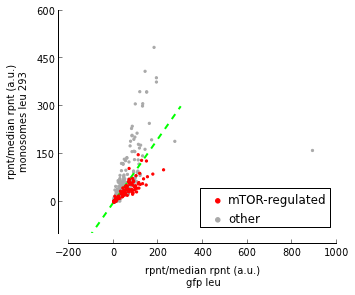

In [42]:
#this code plots differences in translational efficiency in leu vs rich, arg vs rich, and leu vs arg. Outliers may be the pp242 genes, or the top x targets of mTOR inhibition at the level of translational repression.
#goes through x samples one by one and matches it up with the corresponding ySample (I guess this way we only have to iterate through one list, xSamples.
#this needs to be run from a directory containing pp242.csv or change the file path.


from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines

xSamples = [ 'gfp_leu']#,'gfp_rich','gfp_rich','gfp_leu','gfp_rich','gfp_rich','gfp_leu','gfp_arg','gfp_leu','gfp_arg','monosomes_rich293'
            
ySamples = [ 'monosomes_leu293']#,'gfp_arg','gfp_leu','gfp_arg','wtrag_rich','q99lrag_rich','wtrag_leu','wtrag_arg','q99lrag_leu','q99lrag_arg','monosomes_leu293'
            

xLabels = [ 'gfp leu']#, 'rich','rich','leu','rich','rich','leu','arg','leu','arg','rich Rasi' ]
yLabels = [ 'monosomes leu 293']#,'arg', 'leu','arg','wtrag rich','q99lrag rich','wtrag leu','wtrag arg','q99lrag leu','q99lrag arg','leu Rasi']

numberOfPlotsPerLine = 2

fig = plt.figure()

pp242_regulated_genes = list( pandas.read_csv( 'pp242_downregulated_genes.csv' )['refseq'] )

for sampleNumber, xSample in enumerate( xSamples ): 
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
        #conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
        
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
            
    xVector = (data[ 'rpnt_' + xSample ][ subset ])
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ] )
    xMedian = numpy.median(xVector)
    yMedian = numpy.median(yVector)
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
    conditions.append( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) 
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'rpnt_' + xSample ][ subset ]) / xMedian
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ]) / yMedian      
    
    ax = fig.add_subplot( len( xSamples) / numberOfPlotsPerLine + 1, numberOfPlotsPerLine, sampleNumber + 1 )    
    ax.scatter( xVector, yVector, marker='.', color = 'red', label='mTOR-regulated', zorder=15 )
    
    conditions = []
    conditions.append( data[ 'rpnt_' + xSample ]  )
    conditions.append( data[ 'rpnt_' + ySamples[ sampleNumber ] ] )    
    conditions.append( numpy.logical_not( data['refseqid'].apply( lambda x: x.split('.')[0] in pp242_regulated_genes ) ) )    
    
    subset = conditions[0]
    for condition in conditions[1:]:
        subset = numpy.logical_and( subset, condition )   
        
    xVector = (data[ 'rpnt_' + xSample ][ subset ]) / xMedian
    yVector = (data[ 'rpnt_' + ySamples[ sampleNumber ] ][ subset ]) / yMedian   
    
    ax.scatter( xVector, yVector, marker='.', color = 'darkgrey', label='other' )
    
    [ spine.set_position(('outward',10)) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ]    
    
    ax.xaxis.set( ticks_position = 'bottom', major_locator = MaxNLocator(6) )
    ax.yaxis.set( ticks_position = 'left', major_locator = MaxNLocator(6) )
    ax.set( xlabel = 'rpnt/median rpnt (a.u.)\n' + xLabels[ sampleNumber ]  )#,  xlim = (0,300), ylim=(0,450) )
    ax.add_line( mlines.Line2D( (-300, +300), (-300, +300), linewidth=2, linestyle='dashed', color='lime', zorder=10 ) )
    ax.set_ylabel( 'rpnt/median rpnt (a.u.)\n' +  yLabels[ sampleNumber ] ,ha='center' )
    ax.xaxis.labelpad = 10    
    ax.yaxis.labelpad = 20
    temp = ax.legend(loc='lower right', scatterpoints=1, markerscale=2, handletextsep=0)
    
fig.subplots_adjust( hspace = 1, wspace = 0.5 )
fig.set( size_inches = [ 6 * numberOfPlotsPerLine, 8 * len( xSamples) / numberOfPlotsPerLine ] );
fig.savefig( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/geneexp_foldchange_plots/gfpleu_mono293leu.pdf')

# needed to subtract the x and y medians from each data point since xVector and yVector had slightly different median values

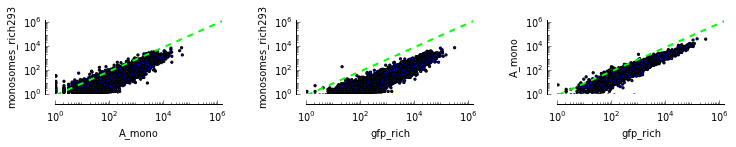

In [34]:
xSamples = [ 'A_mono','gfp_rich','gfp_rich']#'gfp_rich','gfp_rich','gfp_rich','gfp_rich','monosomes_rich293','monosomes_rich293'
            
ySamples = [ 'monosomes_rich293','monosomes_rich293','A_mono']#,'gfp_torin_leu','gfp_torin_arg','monosomes_rich293','wtrag_rich','q99lrag_rich','monosomes_leu293','monosomes_arg293'
            
import matplotlib.lines as mlines
numberOfPlotsPerLine = 3

fig = plt.figure()

for sampleNumber, xSample in enumerate( xSamples ):
    
    xVector = data[ 'counts_' + xSample ]
    yVector = data[ 'counts_' + ySamples[ sampleNumber ] ]
    
    ax = fig.add_subplot( len( xSamples) / numberOfPlotsPerLine + 1, numberOfPlotsPerLine, sampleNumber + 1 )    
    ax.scatter( xVector, yVector, marker='.' )
    
    [ spine.set_position(('outward',10)) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ]    
    
    ax.xaxis.set( ticks_position = 'bottom')
    ax.yaxis.set( ticks_position = 'left' )
    ax.set( xlim = [10**0, 5*10**5.5], ylim = [10**0, 5*10**5.5] , 
            xscale = 'log', yscale = 'log', 
            xlabel = xSamples[ sampleNumber ] , ylabel = ySamples[ sampleNumber ] ,
            )
    ax.set( xticks = ax.get_xticks()[::2], yticks = ax.get_yticks()[::2] )
    ax.add_line( mlines.Line2D( (10**0, 5*10**5.5), (10**0, 5*10**5.5), linewidth=2, linestyle='dashed', color='lime', zorder=10 ) )
    
fig.subplots_adjust( hspace = 1, wspace = 0.5 )
fig.set( size_inches = [ 4 * numberOfPlotsPerLine, 4 * len( xSamples) / numberOfPlotsPerLine ] );
fig.savefig( '/Users/aliciadarnell/processedDataFiles/20140829_293T_q99ltorin/geneexp_foldchange_plots/logscale_counts_AMonovs293monoRasi.png')

In [32]:
print data.keys()

Index([refseqid, rpnt_A_mono, end, start, length, counts_A_mono, counts_gfp_arg, rpnt_gfp_arg, counts_gfp_leu, rpnt_gfp_leu, counts_gfp_rich, rpnt_gfp_rich, counts_gfp_torin_arg, rpnt_gfp_torin_arg, counts_gfp_torin_leu, rpnt_gfp_torin_leu, counts_gfp_torin_rich, rpnt_gfp_torin_rich, counts_monosomes_arg293, rpnt_monosomes_arg293, counts_monosomes_leu293, rpnt_monosomes_leu293, counts_monosomes_rich293, rpnt_monosomes_rich293, counts_q99lrag_arg, rpnt_q99lrag_arg, counts_q99lrag_leu, rpnt_q99lrag_leu, counts_q99lrag_rich, rpnt_q99lrag_rich, counts_wtrag_arg, rpnt_wtrag_arg, counts_wtrag_leu, rpnt_wtrag_leu, counts_wtrag_rich, rpnt_wtrag_rich, description], dtype=object)


In [28]:
from Bio import SeqIO
count = SeqIO.convert("/Users/aliciadarnell/sequence_annotation_files/test.txt", "tab", "custom.fasta", "fasta")
print "Converted %i records" % count

Converted 3 records
